# TP : apprentissage multimodal


Dans ce TP, nous allons utiliser le modèle d'apprentissage, FashionCLIP, pré-entraîné sur des images ainsi que des descriptions en langage naturel. Plus particulièrement, nous allons considérer deux cas d'usage :

*   **Moteur de recherche d'images :** il s'agit de trouver, à partir d'une requête en langage naturel, l'image correspondante.

*   **Classification zero-shot :** il s'agit simplement de construire un classifieur d'images (faire correspondre un label à une image).



## Dataset

Nous allons dans un premier temps télécharger les données. Celles-ci provienennt de [Kaggle](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations).

In [1]:
%%capture
!pip install gdown
!gdown "1igAuIEW_4h_51BG1o05WS0Q0-Cp17_-t&confirm=t"
!unzip data

### Modèle FashionCLIP

Nous allons également télécharger le modèle pré-entraîné.

In [2]:
%%capture
!pip install -U fashion-clip

In [6]:
import sys
#sys.path.append("fashion-clip/")
from fashion_clip.fashion_clip import FashionCLIP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression

In [2]:
%%capture
fclip = FashionCLIP('fashion-clip')

FashionCLIP, à l'instar de CLIP, crée un espace vectoriel partagé pour les images et le texte. Cela permet de nombreuses applications, telles que la recherche (trouver l'image la plus similaire à une requête donnée) ou la classification zero-shot.

Il y a principalement deux composants : un encodeur d'image (pour générer un vecteur à partir d'une image) et un encodeur de texte (pour générer un vecteur à partir d'un texte).










<img src="https://miro.medium.com/v2/resize:fit:1400/0*FLNMtW6jK51fm7Og"  width="400">



Nous allons télécharger les données que nous allons ensuite nettoyer.

In [3]:
articles = pd.read_csv("data_for_fashion_clip/articles.csv")

# Supprimer les éléments ayant la même description
subset = articles.drop_duplicates("detail_desc").copy()

# Supprimer les images dont la catégrie n'est pas renseignée
subset = subset[~subset["product_group_name"].isin(["Unknown"])]

# Garder seulement les descriptions dont la longueur est inférieure à 40 tokens
subset = subset[subset["detail_desc"].apply(lambda x : 4 < len(str(x).split()) < 40)]

# Supprimer les articles qui ne sont pas suffisamment fréquents dans le jeu de données
most_frequent_product_types = [k for k, v in dict(Counter(subset["product_type_name"].tolist())).items() if v > 10]
subset = subset[subset["product_type_name"].isin(most_frequent_product_types)]

subset.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,176754003,176754,2 Row Braided Headband (1),74,Hair/alice band,Accessories,1010016,Solid,17,Yellowish Brown,...,Hair Accessories,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Two-strand hairband with braids in imitation s...
3,189634031,189634,Long Leg Leggings,273,Leggings/Tights,Garment Lower body,1010016,Solid,93,Dark Green,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,Leggings in stretch jersey with an elasticated...


In [5]:
subset.to_csv("subset_data.csv", index=False)
f"Il y a {len(subset)} éléments dans le dataset"

'Il y a 3104 éléments dans le dataset'

## Moteur de recherche d'images

Constuire un moteur de recherche qui permet, à partir d'une description en langage naturel, de récupérer l'image correspondante. Mesurer ses performances (précision).

<img src="https://miro.medium.com/v2/resize:fit:1400/1*cnKHgLAumVyuHuK9pkqr7A.gif"  width="800">


In [4]:
images = ["data_for_fashion_clip/" + str(k) + ".jpg" for k in subset["article_id"].tolist()]
texts = subset["detail_desc"].tolist()

# Créer les représentations vectorielles (embeddings) des images et des descriptions.
image_embeddings = fclip.encode_images(images, batch_size=32)
text_embeddings = fclip.encode_text(texts, batch_size=32)

100%|██████████| 97/97 [02:40<00:00,  1.65s/it]


In [5]:
print(image_embeddings.shape)
print(text_embeddings.shape)

(3104, 512)
(3104, 512)


In [18]:
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    
    return dot_product / (norm_a * norm_b)


def search(word, images, topk = None):
    if (word not in text_embeddings):
        return None
    
    dot = list(map(lambda x : cosine_similarity(x, word), images))

    if (topk != None):
        corresponding_img = np.argsort(dot)[-topk:][::-1]
    else :
        corresponding_img = np.argmax(dot)

    return corresponding_img


In [21]:
def accuracy(texts, images, topk=None):
    acc = 0
    for i, text in enumerate(texts):
        corresponding_img = search(text, images, topk=topk)
        if (not topk and corresponding_img == i):
            acc += 1
        elif(topk):
            for img in corresponding_img:
                if (img == i):
                    acc += 1


    return acc / texts.shape[0]


top1_acc = accuracy(text_embeddings, image_embeddings)
print(f"{top1_acc = }")
top5_acc = accuracy(text_embeddings, image_embeddings, topk=5)
print(f"{top5_acc = }")

top1_acc = 0.2702963917525773
top5_acc = 0.541881443298969


Essayons d'analyser par la précision de classification par catégories

In [25]:
categories = subset["garment_group_name"].unique()
categories

array(['Jersey Basic', 'Accessories', 'Shoes', 'Knitwear',
       'Socks and Tights', 'Jersey Fancy', 'Trousers',
       'Under-, Nightwear', 'Trousers Denim', 'Dresses Ladies', 'Outdoor',
       'Swimwear', 'Shirts', 'Shorts', 'Blouses', 'Special Offers',
       'Skirts', 'Unknown', 'Dresses/Skirts girls', 'Dressed',
       'Woven/Jersey/Knitted mix Baby'], dtype=object)

In [43]:
article_id = subset[['article_id', 'garment_group_name', 'detail_desc']]
article = {}
for cat in categories:
    article[cat] = article_id[article_id['garment_group_name'] == cat]['article_id'].tolist()

article

{'Jersey Basic': [108775044,
  189634031,
  194270044,
  203027047,
  237347052,
  265069012,
  265071028,
  277738002,
  290519008,
  299733001,
  306847002,
  308158016,
  326885051,
  327821030,
  331474033,
  348330045,
  354246021,
  362931025,
  364297018,
  379780024,
  395658039,
  395730042,
  402065030,
  408875019,
  411413021,
  413911035,
  437783003,
  443696005,
  451541006,
  452898030,
  453745026,
  472064006,
  484108014,
  487275012,
  487800035,
  493814004,
  508903014,
  508929064,
  508935032,
  512251006,
  516131006,
  523607008,
  523683001,
  523707006,
  524313001,
  525815002,
  526130001,
  527517010,
  531615007,
  533022003,
  533261011,
  533329013,
  537612005,
  537766005,
  537961002,
  539060008,
  541308008,
  542533022,
  542551018,
  542982017,
  543062007,
  543179001,
  544290034,
  544571043,
  544739040,
  545396004,
  545449019,
  548546001,
  549961015,
  557247005,
  557248021,
  561813004,
  561814002,
  562455001,
  562677003,
  5636350

In [49]:
texts_cat = {}
images_cat = {}
text_embeddings_cat = {}
image_embeddings_cat = {}
for cat in categories:
    garment_group_name = subset[subset['garment_group_name'] == cat]
    images_cat[cat] = ["data_for_fashion_clip/" + str(k) + ".jpg" for k in garment_group_name['article_id'].tolist()]
    texts_cat[cat] = garment_group_name["detail_desc"].tolist()

    image_embeddings_cat[cat] = fclip.encode_images(images_cat[cat], batch_size=32)
    text_embeddings_cat[cat] = fclip.encode_text(texts_cat[cat], batch_size=32)


8it [00:29,  3.71s/it]                       
Map: 100%|██████████| 252/252 [00:00<00:00, 5402.60 examples/s]
8it [00:15,  1.98s/it]                       
11it [00:42,  3.86s/it]                        
Map: 100%|██████████| 325/325 [00:00<00:00, 8305.50 examples/s]
11it [00:19,  1.79s/it]                        
5it [00:19,  3.97s/it]                       
Map: 100%|██████████| 146/146 [00:00<00:00, 7756.60 examples/s]
5it [00:08,  1.76s/it]                       
9it [00:36,  4.10s/it]                       
Map: 100%|██████████| 267/267 [00:00<00:00, 8597.00 examples/s]
9it [00:16,  1.89s/it]                       
2it [00:06,  3.19s/it]                       
Map: 100%|██████████| 49/49 [00:00<00:00, 2593.00 examples/s]
2it [00:02,  1.09s/it]                       
21it [01:07,  3.20s/it]                        
Map: 100%|██████████| 662/662 [00:00<00:00, 9096.84 examples/s]
21it [00:36,  1.74s/it]                        
7it [00:31,  4.45s/it]                       
Map: 100%|██

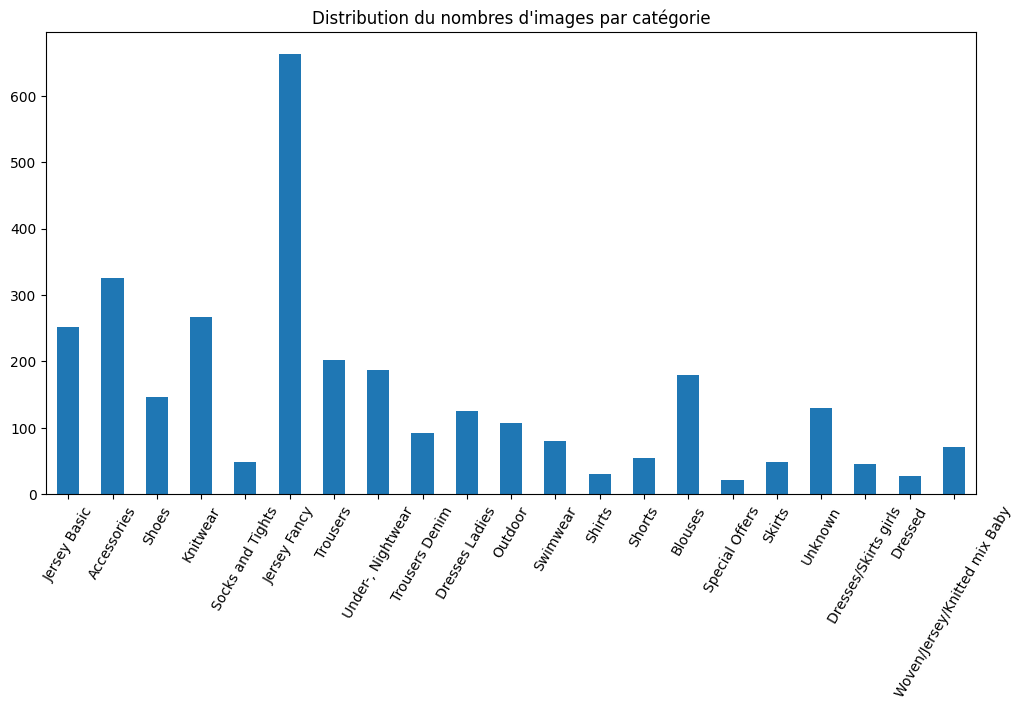

In [65]:
plt.figure(figsize=(12, 6))
plt.title("Distribution du nombres d'images par catégorie")
# plt.hist([len(images_cat[cat]) for cat in categories], bins=list(categories))
pd.Series([len(images_cat[cat]) for cat in categories]).plot(kind='bar')
plt.xticks(list(range(categories.shape[0])), categories, rotation=60)
plt.show()

In [66]:
accuracy_top1_cat = {}
accuracy_top5_cat = {}

for cat in categories:
    accuracy_top1_cat[cat] = accuracy(text_embeddings_cat[cat], image_embeddings_cat[cat])
    accuracy_top5_cat[cat] = accuracy(text_embeddings_cat[cat], image_embeddings_cat[cat], topk=5)

print(f"{accuracy_top1_cat = }")
print(f"{accuracy_top5_cat = }")

accuracy_top1_cat = {'Jersey Basic': 0.31746031746031744, 'Accessories': 0.48307692307692307, 'Shoes': 0.2808219178082192, 'Knitwear': 0.3408239700374532, 'Socks and Tights': 0.22448979591836735, 'Jersey Fancy': 0.3066465256797583, 'Trousers': 0.26732673267326734, 'Under-, Nightwear': 0.20855614973262032, 'Trousers Denim': 0.2391304347826087, 'Dresses Ladies': 0.48412698412698413, 'Outdoor': 0.46296296296296297, 'Swimwear': 0.25925925925925924, 'Shirts': 0.3548387096774194, 'Shorts': 0.37037037037037035, 'Blouses': 0.43333333333333335, 'Special Offers': 0.7142857142857143, 'Skirts': 0.4791666666666667, 'Unknown': 0.6153846153846154, 'Dresses/Skirts girls': 0.6666666666666666, 'Dressed': 0.2222222222222222, 'Woven/Jersey/Knitted mix Baby': 0.704225352112676}
accuracy_top5_cat = {'Jersey Basic': 0.6031746031746031, 'Accessories': 0.8369230769230769, 'Shoes': 0.6301369863013698, 'Knitwear': 0.5917602996254682, 'Socks and Tights': 0.5918367346938775, 'Jersey Fancy': 0.554380664652568, 'Tro

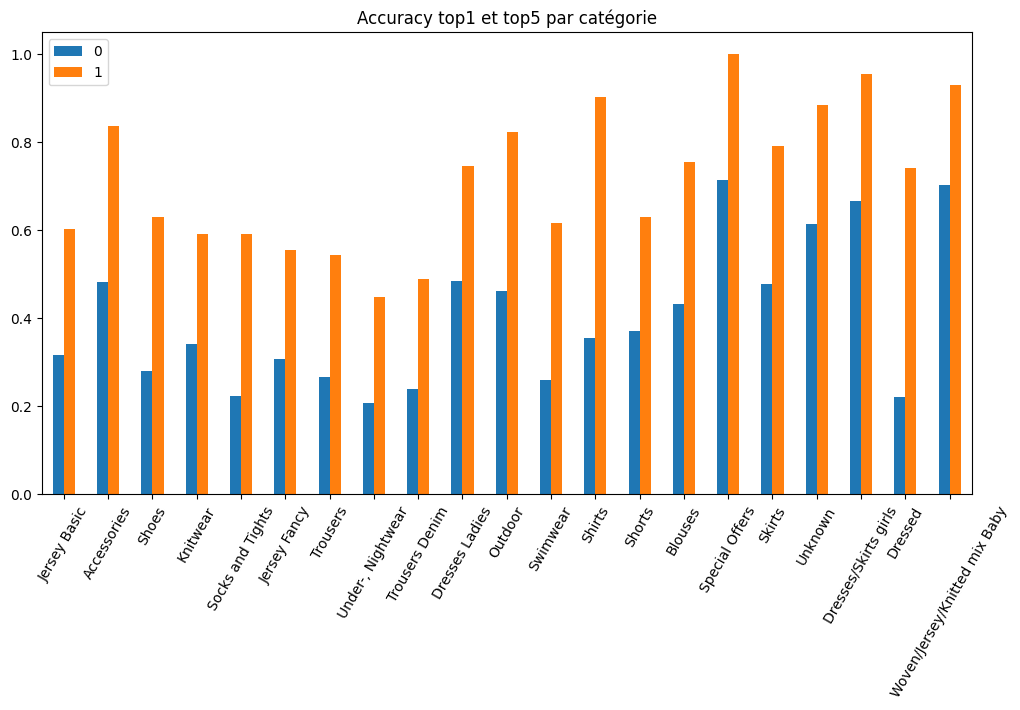

In [85]:
serie_top1 = pd.Series([accuracy_top1_cat[cat] for cat in categories])
serie_top5 = pd.Series([accuracy_top5_cat[cat] for cat in categories])




# plt.hist([len(images_cat[cat]) for cat in categories], bins=list(categories))
pd.concat([serie_top1, serie_top5], axis=1).plot(kind='bar',
                                                 figsize=(12, 6), 
                                                 title="Accuracy top1 et top5 par catégorie")
plt.xticks(list(range(categories.shape[0])), categories, rotation=60)
plt.show()

# Classification zero-shot

Construite un classsifieur d'images (prédire le label d'une image). Mesurer ses performances.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*No6ZONpQMIcfFaNMOI5oNw.gif"  width="800">



In [92]:
classification_texts = [f"A {cat}" for cat in categories]
classification_embeddings = fclip.encode_text(classification_texts, batch_size=32)
classification_texts

Map: 100%|██████████| 21/21 [00:00<00:00, 4273.26 examples/s]
1it [00:00,  1.09it/s]


['A Jersey Basic',
 'A Accessories',
 'A Shoes',
 'A Knitwear',
 'A Socks and Tights',
 'A Jersey Fancy',
 'A Trousers',
 'A Under-, Nightwear',
 'A Trousers Denim',
 'A Dresses Ladies',
 'A Outdoor',
 'A Swimwear',
 'A Shirts',
 'A Shorts',
 'A Blouses',
 'A Special Offers',
 'A Skirts',
 'A Unknown',
 'A Dresses/Skirts girls',
 'A Dressed',
 'A Woven/Jersey/Knitted mix Baby']

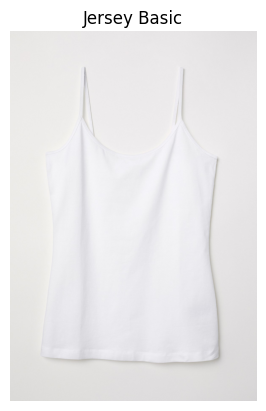

In [91]:
img_ = Image.open(images[0])

plt.title(subset["garment_group_name"].tolist()[0])
plt.imshow(img_)
plt.axis('off')
plt.show()

In [97]:
def sofmax(x): 
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def predict(image, texts):
    cosine_similarities = list(map(lambda x : cosine_similarity(x, image), texts))
    return np.argmax(sofmax(cosine_similarities))


prediction = predict(image_embeddings[0], classification_embeddings)
categories[prediction]

'Shirts'

In [111]:
def accuracy_classification(images, texts):
    accuracy = 0
    reals = []
    predictions = []
    for i, image in enumerate(images):
        prediction = predict(image, texts)
        prediction_category = categories[prediction]
        y = subset["garment_group_name"].tolist()[i]

        reals.append(y)
        predictions.append(prediction)
        if (prediction_category == y):
            accuracy += 1

    return accuracy / len(images), reals, predictions


acc, y, predicts = accuracy_classification(image_embeddings, classification_embeddings)
y = [categories.tolist().index(k) for k in y]
print(f"{acc = }")  

acc = 0.4252577319587629


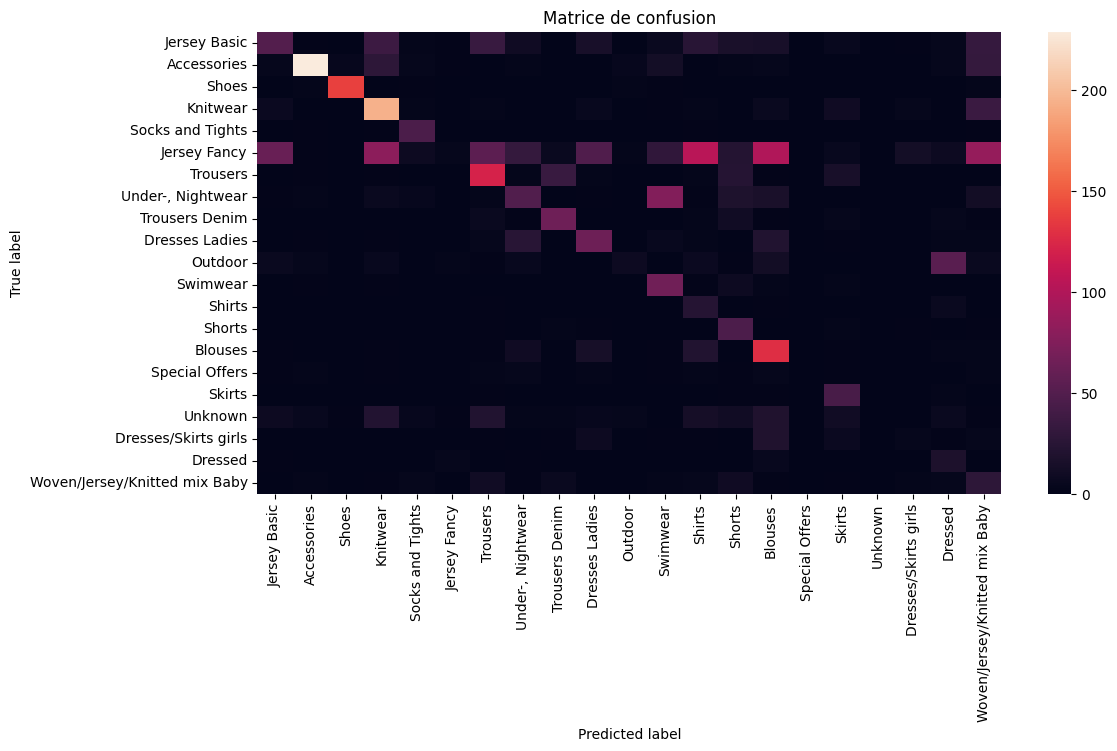

In [117]:
import seaborn as sns

#Confusion Matrix
cm = confusion_matrix(y, predicts)
cm_df = pd.DataFrame(cm,
                     index = categories, 
                     columns = categories)

#plot the confusion matrix
plt.figure(figsize=(12, 6))
plt.title("Matrice de confusion")
sns.heatmap(cm_df, )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


